<a href="https://colab.research.google.com/github/MRsources/MRzero-Core/blob/playground-dev/documentation/playground_mr0/mr0_STE_3pulses_5echoes_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip install pypulseq &> /dev/null
!pip install MRzeroCore &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

In [30]:
import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import matplotlib.pyplot as plt
import math

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

experiment_id = 'STE'

(STE_3pulses_5echoes_seq)=
# STE in a brain phantom

In [31]:
# %% S1. SETUP sys
# choose the scanner limits
system = pp.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time=50 * 10e-6
)

Calculating repetition 3 / 3 - done


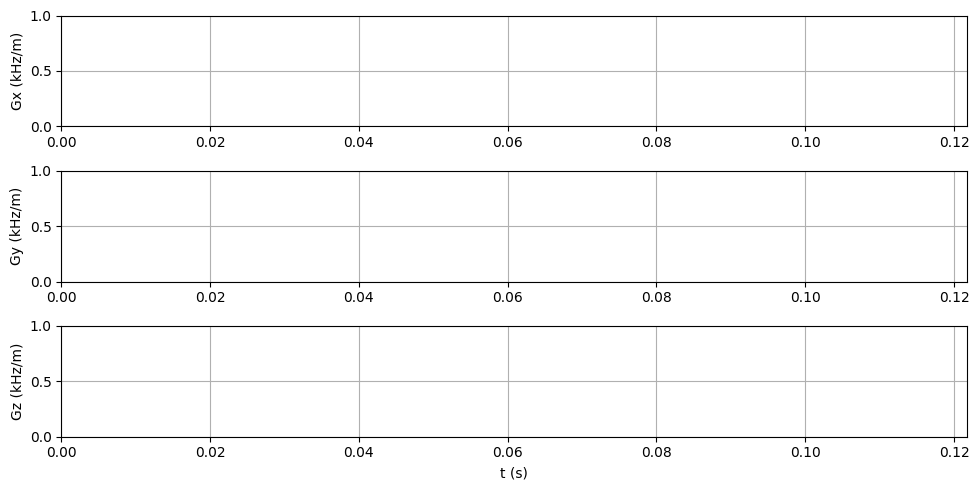

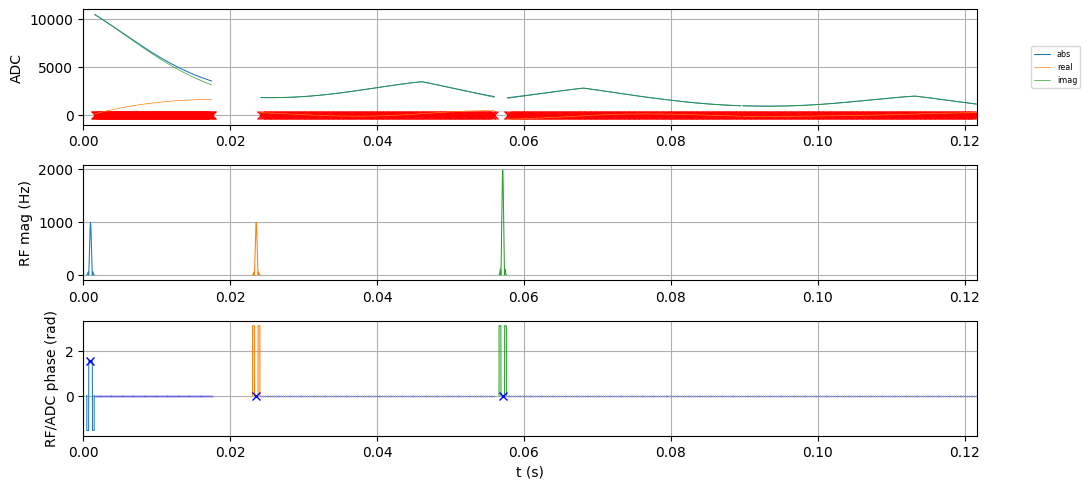

In [32]:
#@title STE in a brain phantom - sequence
# %% S2. DEFINE the sequence, FOV and resolution
seq = pp.Sequence()
fov = 200e-3
Nread = 128
Nphase = 1
slice_thickness = 8e-3  # slice

# Define rf events
rf1, _, _ = pp.make_sinc_pulse(
    flip_angle=90 * np.pi / 180, duration=1e-3, phase_offset=90*np.pi/180,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)
rf2, _, _ = pp.make_sinc_pulse(
    flip_angle=90 * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)
rf3, _, _ = pp.make_sinc_pulse(
    flip_angle=180 * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)
# rf1 = pp.make_block_pulse(flip_angle=90 * np.pi / 180, duration=1e-3, system=system)

# Define other gradients and ADC events

# Define timing according to system raster times
adc_duration_OG = 20e-3
a = int(system.adc_raster_time * Nread * 10**7)
b = int(system.grad_raster_time * 10**7)
c = int(adc_duration_OG * 10**7)
lcm_ab = abs(a * b) // math.gcd(a, b)
adc_raster_duration = (lcm_ab if round(c / lcm_ab) == 0 else round(c / lcm_ab) * lcm_ab) / 10**7

adc1 = pp.make_adc(num_samples=Nread, duration=adc_raster_duration, phase_offset=0 * np.pi / 180, system=system)
adc2 = pp.make_adc(num_samples=Nread, duration=adc_raster_duration*2, phase_offset=0 * np.pi / 180, system=system)
gx = pp.make_trapezoid(channel='x', flat_area=Nread / fov, flat_time=200e-3, system=system)
gx_pre = pp.make_trapezoid(channel='x', area=-gx.area / 2, duration=1e-3, system=system)
gspoil = pp.make_trapezoid(channel='x', area=1000, duration=5e-3, system=system)


# ======
# CONSTRUCT SEQUENCE
# ======
seq.add_block(rf1)
seq.add_block(adc1)
seq.add_block(pp.make_delay(0.005))
seq.add_block(rf2)
seq.add_block(adc2)
# for _ in range(6):
#     seq.add_block(adc2)
seq.add_block(rf3)
seq.add_block(adc2)
seq.add_block(adc2)

#@title quick 2D brain phantom sim and plot
signal = mr0.util.simulate_2d(seq,)
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()

Timing check passed successfully


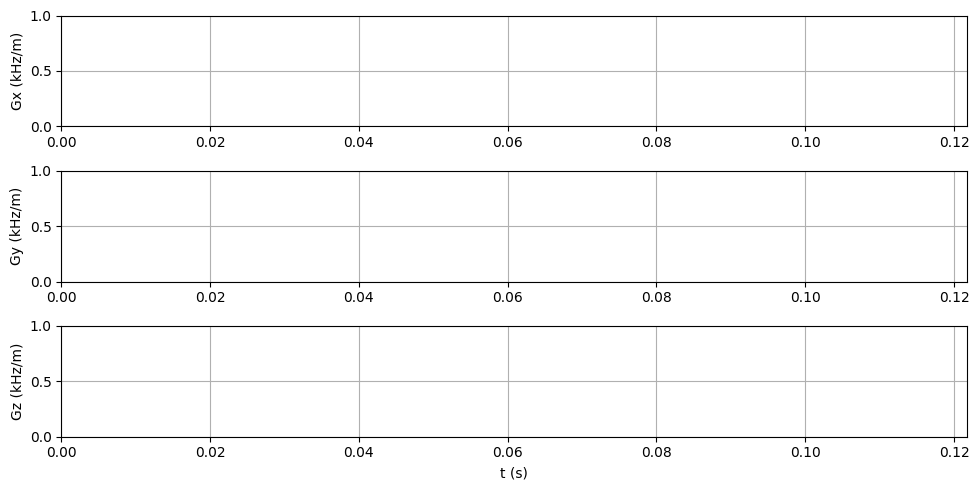

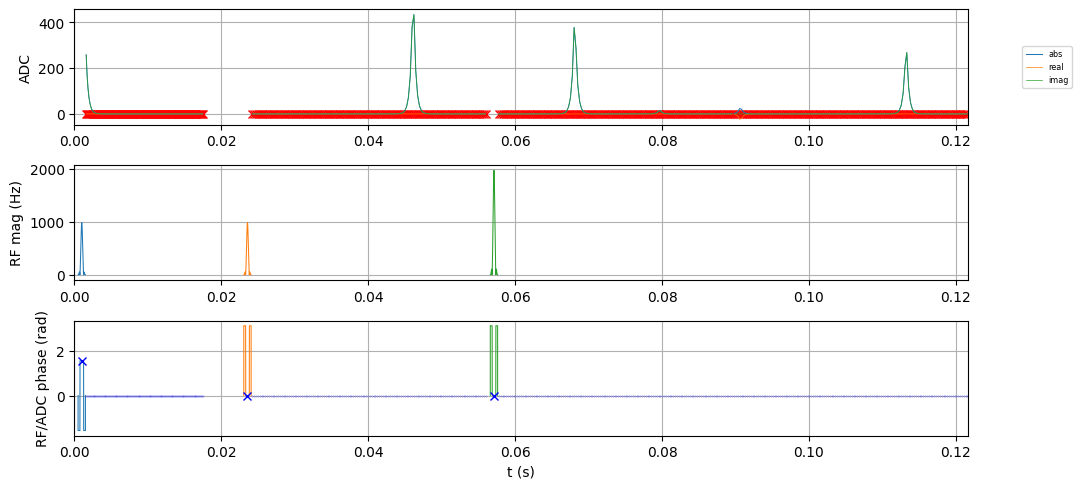

In [33]:
#@title STE in a brain phantom - run
# Prepare the sequence output for the scanner

# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]

seq.set_definition('FOV', [fov, fov, slice_thickness])
seq.set_definition('Name', experiment_id)
seq.write(experiment_id + ".seq")

# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
sz = [64, 64]
obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
obj_p = obj_p.interpolate(sz[0], sz[1], 1)
# Manipulate loaded data
obj_p.B0 *= 0
obj_p.D *= 0
#@markdown Alter T2dash to get sharper echoes.
obj_p.T2dash *= 0.01 #@param {type:'slider', title:"T2dash factor",min:0.01,max:2,step:0.1}
#obj_p.plot()
# Convert Phantom into simulation data
obj_p = obj_p.build()

# %% S5:. SIMULATE  the external.seq file and add acquired signal to ADC plot
# Read in the sequence
seq0 = mr0.Sequence.import_file(experiment_id + ".seq")
# seq0.plot_kspace_trajectory()
# Simulate the sequence
graph = mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal = mr0.execute_graph(graph, seq0, obj_p, print_progress=False)
# PLOT sequence with SIGNAL
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()